In [2]:
import importlib
imported_module1 = importlib.import_module("dynamic_bicycle_model")
importlib.reload(imported_module1)
imported_module2 = importlib.import_module("kinematic_bicycle_model")
importlib.reload(imported_module2)
imported_module3 = importlib.import_module("MPPI_K")
importlib.reload(imported_module3)
imported_module4 = importlib.import_module("MPPI_D")
importlib.reload(imported_module4)

<module 'MPPI_D' from 'c:\\Users\\vdoro\\Documents\\HMMY\\9th_sem\\NeuroFuzzy Control\\MPPI\\code\\MPPI_D.py'>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dynamic_bicycle_model import DBM_Vehicle
from MPPI_K import MPPI_Kinematic
from MPPI_D import MPPI_Dynamic
from kinematic_bicycle_model import KBM_Vehicle

# Main

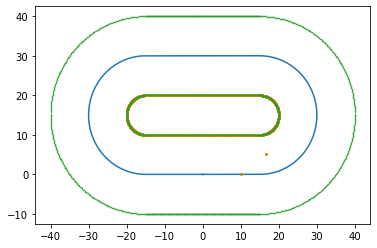

In [4]:
def find_points(a, b):
    a = np.array(a)
    b = np.array(b)

    midpoint = (a + b) / 2
    direction_vector = b - a

    normalized_direction = 10*(direction_vector / np.linalg.norm(direction_vector))
    perpendicular_vector = np.array([-normalized_direction[1], normalized_direction[0]])

    c = midpoint + perpendicular_vector
    d = midpoint - perpendicular_vector
    return c, d

ref_path = np.genfromtxt('./ovalpath.csv', delimiter=',', skip_header=1)

c1 = []
c2 = []
cones = []
for i in range(ref_path.shape[0]-1):
    a = ref_path[i, 0:2]
    b = ref_path[i+1, 0:2]
    c, d = find_points(a, b)
    c1.append(c)
    c2.append(d)
    cones.append(c)
    cones.append(d)

c1 = np.array(c1)
c2 = np.array(c2)
cones = np.array(cones)

c1[100] = ref_path[100, 0:2]
c1[160] = ref_path[160, 0:2] + np.array([0, 5.0])
#c1[150] = ref_path[150, 0:2] + + np.array([3, -4.0])

# cones[250] = ref_path[250, 0:2]
# cones[280] = ref_path[280, 0:2] + np.array([3.5, 0.2])
# cones[500] = ref_path[500, 0:2]
cones[100] = ref_path[100, 0:2] 
cones[160] = ref_path[160, 0:2] + np.array([0, 5.0])
#cones[150] = ref_path[150, 0:2] + np.array([3, -4.0])


cones = cones[cones[:, 0].argsort()]
c1 = c1[c1[:, 0].argsort()]
c2 = c2[c2[:, 0].argsort()]

plt.plot(ref_path[:,0], ref_path[:,1])
plt.plot(c1[:, 0], c1[:, 1], marker='o', linestyle='None', markersize=2)
plt.plot(cones[:, 0], cones[:, 1], marker='o', linestyle='None', markersize=0.5)

In [ ]:

# Kinematic 

##############################################################

# simulation settings
delta_t = 0.05 # [sec]
sim_steps = 500 # [steps]
print(f"[INFO] delta_t : {delta_t:.2f}[s] , sim_steps : {sim_steps}[steps], total_sim_time : {delta_t*sim_steps:.2f}[s]")

# load and visualize reference path
ref_path = np.genfromtxt('./ovalpath.csv', delimiter=',', skip_header=1)
plt.title("Reference Path")
plt.plot(ref_path[:,0], ref_path[:,1])
#plt.plot(c1[:, 0], c1[:, 1], linestyle='--')
plt.plot(c1[:, 0], c1[:, 1], linestyle='--')
plt.plot(c2[:, 0], c2[:, 1], linestyle='--')
plt.show()

# initialize a vehicle as a control target
vehicle = KBM_Vehicle(
    wheel_base=2.5,
    max_steer_abs=0.523, # [rad]
    max_accel_abs=2.000, # [m/s^2]
    ref_path = ref_path[:, 0:2], # ndarray, size is <num_of_waypoints x 2>
    input_map = (c1, c2)
)


vehicle.reset(
    init_state = np.array([0.0, 1.0, 0.0, 0.0]), # [x[m], y[m], yaw[rad], v[m/s]]
)
vehicle_trajectory = np.array([vehicle.get_state()[:2]])

# initialize a mppi controller for the vehicle
mppi = MPPI_Kinematic(
    delta_t = delta_t*2.0, # [s]
    wheel_base = 2.5, # [m]
    max_steer_abs = 0.523, # [rad]
    max_accel_abs = 2.000, # [m/s^2]
    ref_path = ref_path, # ndarray, size is <num_of_waypoints x 2>
    horizon_step_T = 20, # [steps]
    number_of_samples_K = 20, # [samples]
    param_exploration = 0.0,
    param_lambda = 100.0,
    param_alpha = 0.98,
    sigma = np.array([[0.075, 0.0], [0.0, 2.0]]),
    stage_cost_weight = np.array([50.0, 50.0, 1.0, 20.0]), # weight for [x, y, yaw, v]
    terminal_cost_weight = np.array([50.0, 50.0, 1.0, 20.0]), # weight for [x, y, yaw, v]
    visualze_sampled_trajs = True,
    input_map = (c1, c2)
)

# simulation loop
for i in range(sim_steps):

    # get current state of vehicle
    current_state = vehicle.get_state()

    try:
        # calculate input force with MPPI
        optimal_input, optimal_input_sequence, optimal_traj, sampled_traj_list = mppi.calc_control_input(
            observed_x = current_state
        )
    except IndexError as e:
        # the vehicle has reached the end of the reference path
        print("[ERROR] IndexError detected. Terminate simulation.")
        break

    # print current state and input force
    print(f"Time: {i*delta_t:>2.2f}[s], x={current_state[0]:>+3.3f}[m], y={current_state[1]:>+3.3f}[m], yaw={current_state[2]:>+3.3f}[rad], v={current_state[3]:>+3.3f}[m/s], steer={optimal_input[0]:>+6.2f}[rad], accel={optimal_input[1]:>+6.2f}[m/s]")

    # update states of vehicle
    vehicle.update(u=optimal_input, delta_t=delta_t, vehicle_traj=vehicle_trajectory, optimal_traj=optimal_traj[:, 0:2], sampled_traj_list=sampled_traj_list[:, :, 0:2])
    vehicle_trajectory = np.vstack((vehicle_trajectory, vehicle.get_state()[:2])) # record vehicle trajectory

# show animation
#vehicle.show_animation(interval_ms=int(delta_t * 1000))
    
# save animation
vehicle.save_animation("mppi_test_KBM.mp4", interval=int(delta_t * 1000), movie_writer="ffmpeg") # ffmpeg is required to write mp4 file

In [ ]:
# Dynamic 
##############################################################

# simulation settings
delta_t = 0.05 # [sec]
sim_steps = 500 # [steps]
print(f"[INFO] delta_t : {delta_t:.2f}[s] , sim_steps : {sim_steps}[steps], total_sim_time : {delta_t*sim_steps:.2f}[s]")

# load and visualize reference path
ref_path = np.genfromtxt('./ovalpath.csv', delimiter=',', skip_header=1)
plt.title("Reference Path")
plt.plot(ref_path[:,0], ref_path[:,1])
#plt.plot(c1[:, 0], c1[:, 1], linestyle='--')
plt.plot(cones[:, 0], cones[:, 1],  marker='o', linestyle='None', markersize=2)
#plt.plot(c2[:, 0], c2[:, 1], linestyle='--')
plt.show()

# initialize a vehicle as a control target
vehicle = DBM_Vehicle(
    delta_t = 0.05,
    l_f = 1.1, # [m]
    l_r = 1.4, # [m]
    mass = 1000.0, # [kg]
    I_z = 1300.0, # [kg*m^2]
    C_f = 5000.0 * 2.0, # [N/rad]
    C_r = 6000.0 * 2.0, # [N/rad]
    max_steer_abs=0.523, # [rad]
    max_accel_abs=2.000, # [m/s^2]
    ref_path = ref_path[:, 0:2], # ndarray, size is <num_of_waypoints x 2>
    input_map = (c1, c2),
    cones = cones,
)

vehicle.reset(
    init_state = np.array([-20.0, 0.0, 0.0, 7.0, 0.0, 0.0]), # [x[m], y[m], yaw[rad], vx[m/s], vy[m/s], omega[rad/s]]
)
vehicle_trajectory = np.array([vehicle.get_state()[:2]])

# initialize a mppi controller for the vehicle
mppi = MPPI_Dynamic(
    delta_t = 0.05,
    l_f = 1.1, # [m]
    l_r = 1.4, # [m]
    mass = 1000.0, # [kg]
    I_z = 1300.0, # [kg*m^2]
    C_f = 5000.0 * 2.0, # [N/rad]
    C_r = 6000.0 * 2.0, # [N/rad]
    max_steer_abs =  0.523, # [rad]
    max_accel_abs = 2.000, # [m/s^2]
    ref_path = ref_path, # ndarray, size is <num_of_waypoints x 2>
    horizon_step_T = 80, # [steps]
    number_of_samples_K = 600, # [samples]
    param_exploration = 0.0,
    param_lambda = 100.0,
    param_alpha = 0.98,
    sigma = np.array([[0.25, 0.0], [0.0, 1.0]]),
    stage_cost_weight = np.array([200.0, 500.0, 1.0, 20.0]), # weight for [x, y, yaw, v]
    terminal_cost_weight = np.array([200.0, 500.0, 1.0, 20.0]), # weight for [x, y, yaw, v]
    visualze_sampled_trajs = True,
    input_map = (c1, c2),
    cones = cones
)

# simulation loop
for i in range(sim_steps):

    # get current state of vehicle
    current_state = vehicle.get_state()

    # try:
    #     # calculate input force with MPPI
    #     optimal_input, optimal_input_sequence, optimal_traj, sampled_traj_list = mppi.calc_control_input(
    #         observed_x = current_state
    #     )
    # except IndexError as e:
    #     # the vehicle has reached the end of the reference path
    #     print("[ERROR] IndexError detected. Terminate simulation.")
    #     break

    # calculate input force with MPPI
    optimal_input, optimal_input_sequence, optimal_traj, sampled_traj_list = mppi.calc_control_input(
        observed_x = current_state
    )
    # print current state and input force
    print(f"Time: {i*delta_t:>2.2f}[s], x={current_state[0]:>+3.3f}[m], y={current_state[1]:>+3.3f}[m], yaw={current_state[2]:>+3.3f}[rad], vx={current_state[3]:>+3.3f}[m/s], vy={current_state[4]:>+3.3f}[m/s], steer={optimal_input[0]:>+6.2f}[rad], accel={optimal_input[1]:>+6.2f}[m/s^2]")
    
    #if(current_state[0] > 24 or current_state[0] < -12): break

    # update states of vehicle
    vehicle.update(u=optimal_input, delta_t=delta_t, vehicle_traj=vehicle_trajectory, optimal_traj=optimal_traj[:, 0:2], sampled_traj_list=sampled_traj_list[:, :, 0:2])
    vehicle_trajectory = np.vstack((vehicle_trajectory, vehicle.get_state()[:2])) # record vehicle trajectory

# show animation
#vehicle.show_animation(interval_ms=int(delta_t * 1000))
    
# save animation
vehicle.save_animation("mppi_test_100_160_larger_T.mp4", interval=int(delta_t * 1000), movie_writer="ffmpeg") # ffmpeg is required to write mp4 file

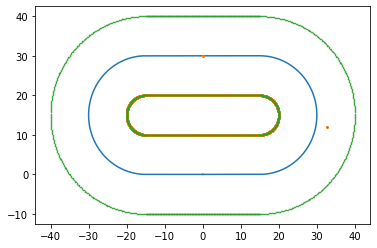

In [77]:
def find_points(a, b):
    a = np.array(a)
    b = np.array(b)

    midpoint = (a + b) / 2
    direction_vector = b - a

    normalized_direction = 10*(direction_vector / np.linalg.norm(direction_vector))
    perpendicular_vector = np.array([-normalized_direction[1], normalized_direction[0]])

    c = midpoint + perpendicular_vector
    d = midpoint - perpendicular_vector
    return c, d

ref_path = np.genfromtxt('./ovalpath.csv', delimiter=',', skip_header=1)

c1 = []
c2 = []
cones = []
for i in range(ref_path.shape[0]-1):
    a = ref_path[i, 0:2]
    b = ref_path[i+1, 0:2]
    c, d = find_points(a, b)
    c1.append(c)
    c2.append(d)
    cones.append(c)
    cones.append(d)

c1 = np.array(c1)
c2 = np.array(c2)
cones = np.array(cones)

c1[280] = ref_path[280, 0:2] + np.array([3.0, 0.0])
c1[600] = ref_path[600, 0:2]
#c1[150] = ref_path[150, 0:2] + + np.array([3, -4.0])

# cones[250] = ref_path[250, 0:2]
# cones[280] = ref_path[280, 0:2] + np.array([3.5, 0.2])
# cones[500] = ref_path[500, 0:2]
cones[280] = ref_path[280, 0:2] + np.array([3.0, 0.0])
c1[600] = ref_path[600, 0:2]
#cones[150] = ref_path[150, 0:2] + np.array([3, -4.0])


cones = cones[cones[:, 0].argsort()]
c1 = c1[c1[:, 0].argsort()]
c2 = c2[c2[:, 0].argsort()]

plt.plot(ref_path[:,0], ref_path[:,1])
plt.plot(c1[:, 0], c1[:, 1], marker='o', linestyle='None', markersize=2)
plt.plot(cones[:, 0], cones[:, 1], marker='o', linestyle='None', markersize=0.5)

[INFO] delta_t : 0.05[s] , sim_steps : 500[steps], total_sim_time : 25.00[s]


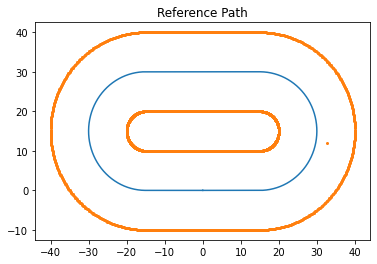

Time: 0.00[s], x=+0.000[m], y=+0.000[m], yaw=+0.000[rad], vx=+6.000[m/s], vy=+0.000[m/s], steer= -0.02[rad], accel= +0.33[m/s^2]
Time: 0.05[s], x=+0.300[m], y=+0.000[m], yaw=+0.000[rad], vx=+6.016[m/s], vy=-0.008[m/s], steer= -0.02[rad], accel= +0.54[m/s^2]
Time: 0.10[s], x=+0.601[m], y=-0.000[m], yaw=-0.000[rad], vx=+6.043[m/s], vy=-0.013[m/s], steer= -0.01[rad], accel= +0.87[m/s^2]
Time: 0.15[s], x=+0.903[m], y=-0.001[m], yaw=-0.001[rad], vx=+6.087[m/s], vy=-0.013[m/s], steer= -0.00[rad], accel= +1.05[m/s^2]
Time: 0.20[s], x=+1.207[m], y=-0.002[m], yaw=-0.002[rad], vx=+6.139[m/s], vy=-0.008[m/s], steer= +0.02[rad], accel= +1.26[m/s^2]
Time: 0.25[s], x=+1.514[m], y=-0.003[m], yaw=-0.002[rad], vx=+6.202[m/s], vy=+0.007[m/s], steer= -0.01[rad], accel= +1.53[m/s^2]
Time: 0.30[s], x=+1.824[m], y=-0.003[m], yaw=-0.002[rad], vx=+6.278[m/s], vy=+0.002[m/s], steer= +0.01[rad], accel= +1.68[m/s^2]
Time: 0.35[s], x=+2.138[m], y=-0.004[m], yaw=-0.003[rad], vx=+6.362[m/s], vy=+0.010[m/s], steer= 

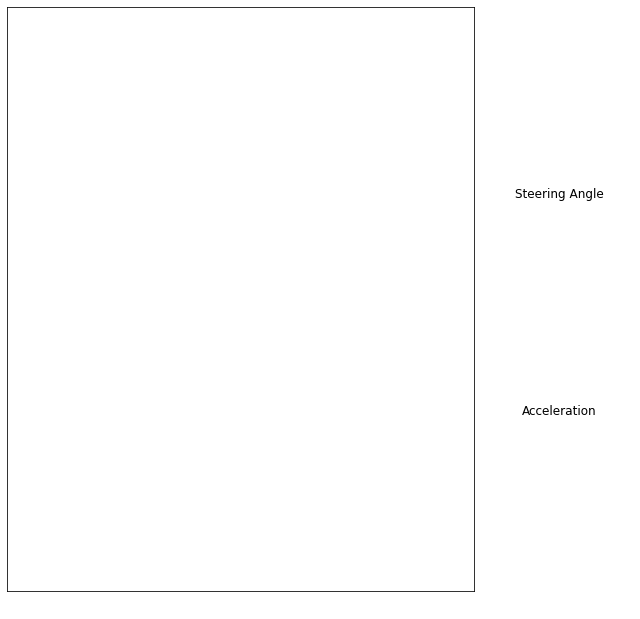

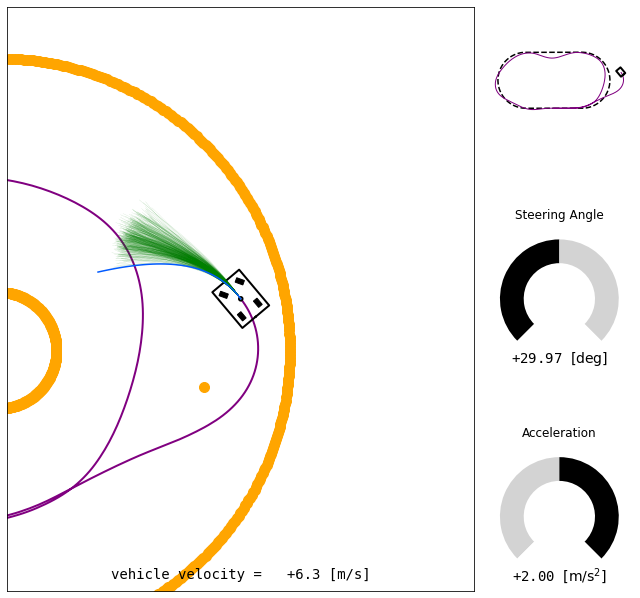

In [80]:
# Dynamic 
##############################################################

# simulation settings
delta_t = 0.05 # [sec]
sim_steps = 500 # [steps]
print(f"[INFO] delta_t : {delta_t:.2f}[s] , sim_steps : {sim_steps}[steps], total_sim_time : {delta_t*sim_steps:.2f}[s]")

# load and visualize reference path
ref_path = np.genfromtxt('./ovalpath.csv', delimiter=',', skip_header=1)
plt.title("Reference Path")
plt.plot(ref_path[:,0], ref_path[:,1])
#plt.plot(c1[:, 0], c1[:, 1], linestyle='--')
plt.plot(cones[:, 0], cones[:, 1],  marker='o', linestyle='None', markersize=2)
#plt.plot(c2[:, 0], c2[:, 1], linestyle='--')
plt.show()

# initialize a vehicle as a control target
vehicle = DBM_Vehicle(
    delta_t = 0.05,
    l_f = 1.1, # [m]
    l_r = 1.4, # [m]
    mass = 1000.0, # [kg]
    I_z = 1300.0, # [kg*m^2]
    C_f = 5000.0 * 2.0, # [N/rad]
    C_r = 6000.0 * 2.0, # [N/rad]
    max_steer_abs=0.523, # [rad]
    max_accel_abs=2.000, # [m/s^2]
    ref_path = ref_path[:, 0:2], # ndarray, size is <num_of_waypoints x 2>
    input_map = (c1, c2),
    cones = cones,
)

vehicle.reset(
    init_state = np.array([0.0, 0.0, 0.0, 6.0, 0.0, 0.0]), # [x[m], y[m], yaw[rad], vx[m/s], vy[m/s], omega[rad/s]]
)
vehicle_trajectory = np.array([vehicle.get_state()[:2]])

# initialize a mppi controller for the vehicle
mppi = MPPI_Dynamic(
    delta_t = 0.05,
    l_f = 1.1, # [m]
    l_r = 1.4, # [m]
    mass = 1000.0, # [kg]
    I_z = 1300.0, # [kg*m^2]
    C_f = 5000.0 * 2.0, # [N/rad]
    C_r = 6000.0 * 2.0, # [N/rad]
    max_steer_abs =  0.523, # [rad]
    max_accel_abs = 2.000, # [m/s^2]
    ref_path = ref_path, # ndarray, size is <num_of_waypoints x 2>
    horizon_step_T = 40, # [steps]
    number_of_samples_K = 500, # [samples]
    param_exploration = 0.0,
    param_lambda = 100.0,
    param_alpha = 0.98,
    sigma = np.array([[0.5, 0.0], [0.0, 2.0]]),
    stage_cost_weight = np.array([200.0, 500.0, 1.0, 20.0]), # weight for [x, y, yaw, v]
    terminal_cost_weight = np.array([200.0, 500.0, 1.0, 20.0]), # weight for [x, y, yaw, v]
    visualze_sampled_trajs = True,
    input_map = (c1, c2),
    cones = cones
)

train_model_data = []
current_state_true_dynamics = []
controls_true_dynamics = []
# simulation loop
for i in range(sim_steps):

    # get current state of vehicle
    current_state = vehicle.get_state()
    #if(i > 0): train_model_data.append((action, prev_state, current_state))

    # try:
    #     # calculate input force with MPPI
    #     optimal_input, optimal_input_sequence, optimal_traj, sampled_traj_list = mppi.calc_control_input(
    #         observed_x = current_state
    #     )
    # except IndexError as e:
    #     # the vehicle has reached the end of the reference path
    #     print("[ERROR] IndexError detected. Terminate simulation.")
    #     break

    # calculate input force with MPPI
    optimal_input, optimal_input_sequence, optimal_traj, sampled_traj_list = mppi.calc_control_input(
        observed_x = current_state
    )
    # print current state and input force
    print(f"Time: {i*delta_t:>2.2f}[s], x={current_state[0]:>+3.3f}[m], y={current_state[1]:>+3.3f}[m], yaw={current_state[2]:>+3.3f}[rad], vx={current_state[3]:>+3.3f}[m/s], vy={current_state[4]:>+3.3f}[m/s], steer={optimal_input[0]:>+6.2f}[rad], accel={optimal_input[1]:>+6.2f}[m/s^2]")
    
    action = optimal_input
    prev_state = current_state
    current_state_true_dynamics.append(current_state)
    controls_true_dynamics.append(optimal_input)
    # update states of vehicle
    vehicle.update(u=optimal_input, delta_t=delta_t, vehicle_traj=vehicle_trajectory, optimal_traj=optimal_traj[:, 0:2], sampled_traj_list=sampled_traj_list[:, :, 0:2])
    vehicle_trajectory = np.vstack((vehicle_trajectory, vehicle.get_state()[:2])) # record vehicle trajectory
    
# save animation
vehicle.save_animation("mppi_test_dynamics_true_large_sigma.mp4", interval=int(delta_t * 1000), movie_writer="ffmpeg") # ffmpeg is required to write mp4 file

In [79]:
current_state_false_dynamics = np.array(current_state_false_dynamics)
#current_state_true_dynamics = np.array(current_state_true_dynamics)
#controls_true_dynamics = np.array(controls_true_dynamics)
controls_false_dynamics = np.array(controls_false_dynamics)
# x_false = current_state_false_dynamics[:, 0]
# x_true = current_state_true_dynamics[:, 0]
# y_false = current_state_false_dynamics[:, 1]
# y_true = current_state_true_dynamics[:, 1]
# yaw_false = current_state_false_dynamics[:, 2]
# yaw_true = current_state_true_dynamics[:, 2]
# vx_false = current_state_false_dynamics[:, 3]
# vx_true = current_state_true_dynamics[:, 3]
# vy_false = current_state_false_dynamics[:, 4]
# vy_true = current_state_true_dynamics[:, 4]
# omega_false = current_state_false_dynamics[:, 5]
# omega_true = current_state_true_dynamics[:, 5]

Text(0.5, 1.0, "vehicle's trajectory - true vs false dynamics")

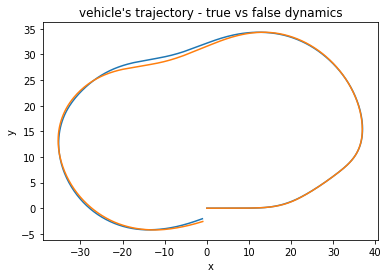

In [64]:
plt.plot(x_false, y_false)
plt.plot(x_true, y_true)
plt.xlabel("x")
plt.ylabel("y")
plt.title("vehicle's trajectory - true vs false dynamics" )

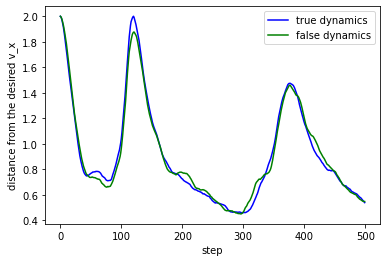

In [69]:
v_des_true = np.abs(vx_true - 8.0)
v_des_false = np.abs(vx_false - 8.0)
plt.plot(t, v_des_true, color="blue", label='true dynamics')
plt.plot(t, v_des_false, color="green", label='false dynamics')
plt.xlabel("step")
plt.ylabel("distance from the desired v_x")
plt.legend()


Text(0, 0.5, 'vx_true')

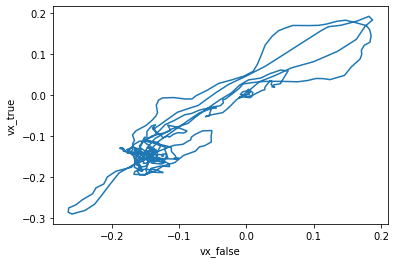

In [73]:
plt.plot(vy_false, vy_true)
plt.xlabel('vx_false')
plt.ylabel('vx_true')

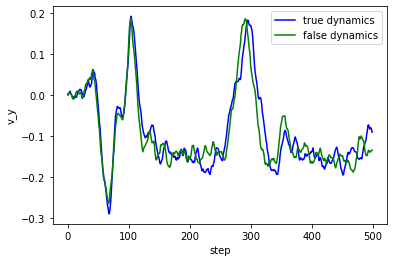

In [75]:
plt.plot(t, vy_true, color="blue", label='true dynamics')
plt.plot(t, vy_false, color="green", label='false dynamics')
plt.xlabel("step")
plt.ylabel("v_y")
plt.legend()